# How many cases of COVID-19 does each U.S. state really have?
> Reported U.S. case counts are based on the number of administered tests. Since not everyone is tested, this number is biased. We use Bayesian techniques to estimate the true number of cases.

- author: Joseph Richards
- image: images/covid-state-case-estimation.png
- hide: false
- comments: true
- categories: [MCMC, US, states, cases]
- permalink: /covid-19-us-case-estimation/
- toc: false

> Note: This dashboard contains the results of a predictive model. The author has tried to make it as accurate as possible. But the COVID-19 situation is changing quickly, and these models inevitably include some level of speculation.

In [1]:
#hide

# Setup and imports
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import requests

from IPython.display import display, Markdown

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#hide

# Data utilities:

def get_statewise_testing_data():
    '''
    Pull all statewise data required for model fitting and
    prediction

    Returns:
    * df_out: DataFrame for model fitting where inclusion
        requires testing data from 7 days ago
    * df_pred: DataFrame for count prediction where inclusion
        only requires testing data from today
    '''

    # Pull testing counts by state:
    out = requests.get('https://covidtracking.com/api/states')
    df_out = pd.DataFrame(out.json())
    df_out.set_index('state', drop=True, inplace=True)

    # Pull time-series of testing counts:
    ts = requests.get('https://covidtracking.com/api/states/daily')
    df_ts = pd.DataFrame(ts.json())

    # Get data from last week
    date_last_week = df_ts['date'].unique()[7]
    df_ts_last_week = _get_test_counts(df_ts, df_out.index, date_last_week)
    df_out['num_tests_7_days_ago'] = \
        (df_ts_last_week['positive'] + df_ts_last_week['negative'])
    df_out['num_pos_7_days_ago'] = df_ts_last_week['positive']

    # Get data from today:
    df_out['num_tests_today'] = (df_out['positive'] + df_out['negative'])

    # State population:
    df_pop = pd.read_excel(('https://github.com/jwrichar/COVID19-mortality/blob/'
                            'master/data/us_population_by_state_2019.xlsx?raw=true'),
                           skiprows=2, skipfooter=5)
    r = requests.get(('https://raw.githubusercontent.com/jwrichar/COVID19-mortality/'
                      'master/data/us-state-name-abbr.json'))
    state_name_abbr_lookup = r.json()
    
    df_pop.index = df_pop['Geographic Area'].apply(
        lambda x: str(x).replace('.', '')).map(state_name_abbr_lookup)
    df_pop = df_pop.loc[df_pop.index.dropna()]

    df_out['total_population'] = df_pop['Total Resident\nPopulation']

    # Tests per million people, based on today's test coverage
    df_out['tests_per_million'] = 1e6 * \
        (df_out['num_tests_today']) / df_out['total_population']
    df_out['tests_per_million_7_days_ago'] = 1e6 * \
        (df_out['num_tests_7_days_ago']) / df_out['total_population']

    # People per test:
    df_out['people_per_test'] = 1e6 / df_out['tests_per_million']
    df_out['people_per_test_7_days_ago'] = \
        1e6 / df_out['tests_per_million_7_days_ago']

    # Drop states with messed up / missing data:
    # Drop states with missing total pop:
    to_drop_idx = df_out.index[df_out['total_population'].isnull()]
    print('Dropping %i/%i states due to lack of population data: %s' %
          (len(to_drop_idx), len(df_out), ', '.join(to_drop_idx)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)

    df_pred = df_out.copy(deep=True)  # Prediction DataFrame

    # Criteria for model fitting:
    # Drop states with missing test count 7 days ago:
    to_drop_idx = df_out.index[df_out['num_tests_7_days_ago'].isnull()]
    print('Dropping %i/%i states due to lack of tests: %s' %
          (len(to_drop_idx), len(df_out), ', '.join(to_drop_idx)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)
    # Drop states with no cases 7 days ago:
    to_drop_idx = df_out.index[df_out['num_pos_7_days_ago'] == 0]
    print('Dropping %i/%i states due to lack of positive tests: %s' %
          (len(to_drop_idx), len(df_out), ', '.join(to_drop_idx)))
    df_out.drop(to_drop_idx, axis=0, inplace=True)

    # Criteria for model prediction:
    # Drop states with missing test count today:
    to_drop_idx = df_pred.index[df_pred['num_tests_today'].isnull()]
    print('Dropping %i/%i states in prediction data due to lack of tests: %s' %
          (len(to_drop_idx), len(df_pred), ', '.join(to_drop_idx)))
    df_pred.drop(to_drop_idx, axis=0, inplace=True)
    # Cast counts to int
    df_pred['negative'] = df_pred['negative'].astype(int)
    df_pred['positive'] = df_pred['positive'].astype(int)

    return df_out, df_pred

def _get_test_counts(df_ts, state_list, date):

    ts_list = []
    for state in state_list:
        state_ts = df_ts.loc[df_ts['state'] == state]
        # Back-fill any gaps to avoid crap data gaps
        state_ts.fillna(method='bfill', inplace=True)

        record = state_ts.loc[df_ts['date'] == date]
        ts_list.append(record)

    df_ts = pd.concat(ts_list, ignore_index=True)
    return df_ts.set_index('state', drop=True)


In [3]:
#hide

# Model utilities

def case_count_model_us_states(df):

    # Normalize inputs in a way that is sensible:

    # People per test: normalize to South Korea
    # assuming S.K. testing is "saturated"
    ppt_sk = np.log10(51500000. / 250000)
    df['people_per_test_normalized'] = (
        np.log10(df['people_per_test_7_days_ago']) - ppt_sk)

    n = len(df)

    # For each country, let:
    # c_obs = number of observed cases
    c_obs = df['num_pos_7_days_ago'].values
    # c_star = number of true cases

    # d_obs = number of observed deaths
    d_obs = df[['death', 'num_pos_7_days_ago']].min(axis=1).values
    # people per test
    people_per_test = df['people_per_test_normalized'].values

    covid_case_count_model = pm.Model()

    with covid_case_count_model:

        # Priors:
        mu_0 = pm.Beta('mu_0', alpha=1, beta=100, testval=0.01)
        # sig_0 = pm.Uniform('sig_0', lower=0.0, upper=mu_0 * (1 - mu_0))
        alpha = pm.Bound(pm.Normal, lower=0.0)(
            'alpha', mu=8, sigma=3, shape=1)
        beta = pm.Bound(pm.Normal, upper=0.0)(
            'beta', mu=-1, sigma=1, shape=1)
        # beta = pm.Normal('beta', mu=0, sigma=1, shape=3)
        sigma = pm.HalfNormal('sigma', sigma=0.5, testval=0.1)
        # sigma_1 = pm.HalfNormal('sigma_1', sigma=2, testval=0.1)

        # Model probability of case under-reporting as logistic regression:
        mu_model_logit = alpha + beta * people_per_test
        tau_logit = pm.Normal('tau_logit',
                              mu=mu_model_logit,
                              sigma=sigma,
                              shape=n)
        tau = np.exp(tau_logit) / (np.exp(tau_logit) + 1)

        c_star = c_obs / tau

        # Binomial likelihood:
        d = pm.Binomial('d',
                        n=c_star,
                        p=mu_0,
                        observed=d_obs)

    return covid_case_count_model

In [4]:
#hide

df, df_pred = get_statewise_testing_data()

# Initialize the model:
mod = case_count_model_us_states(df)

# Run MCMC sampler
with mod:
    trace = pm.sample(500, tune=500, chains=1)

Dropping 4/56 states due to lack of population data: AS, GU, MP, VI
Dropping 0/52 states due to lack of tests: 
Dropping 0/52 states due to lack of positive tests: 
Dropping 1/52 states in prediction data due to lack of tests: PR


Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Sequential sampling (1 chains in 1 job)


NUTS: [tau_logit, sigma, beta, alpha, mu_0]


Sampling chain 0, 0 divergences:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling chain 0, 0 divergences:   0%|          | 1/1000 [00:01<20:20,  1.22s/it]

Sampling chain 0, 0 divergences:   2%|▏         | 15/1000 [00:01<14:05,  1.17it/s]

Sampling chain 0, 0 divergences:   2%|▏         | 18/1000 [00:01<10:07,  1.62it/s]

Sampling chain 0, 0 divergences:   2%|▏         | 21/1000 [00:01<07:23,  2.21it/s]

Sampling chain 0, 0 divergences:   2%|▏         | 24/1000 [00:01<05:27,  2.98it/s]

Sampling chain 0, 0 divergences:   3%|▎         | 26/1000 [00:02<04:07,  3.94it/s]

Sampling chain 0, 0 divergences:   3%|▎         | 28/1000 [00:02<03:10,  5.09it/s]

Sampling chain 0, 0 divergences:   3%|▎         | 30/1000 [00:02<02:31,  6.38it/s]

Sampling chain 0, 0 divergences:   3%|▎         | 32/1000 [00:02<02:04,  7.76it/s]

Sampling chain 0, 0 divergences:   3%|▎         | 34/1000 [00:02<01:46,  9.10it/s]

Sampling chain 0, 0 divergences:   4%|▎         | 36/1000 [00:02<01:33, 10.34it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 38/1000 [00:02<01:23, 11.57it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 40/1000 [00:02<01:16, 12.49it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 42/1000 [00:03<01:11, 13.42it/s]

Sampling chain 0, 0 divergences:   4%|▍         | 44/1000 [00:03<01:07, 14.10it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 46/1000 [00:03<01:04, 14.70it/s]

Sampling chain 0, 0 divergences:   5%|▍         | 48/1000 [00:03<01:03, 14.97it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 50/1000 [00:03<01:03, 14.96it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 52/1000 [00:03<01:02, 15.09it/s]

Sampling chain 0, 0 divergences:   5%|▌         | 54/1000 [00:03<01:01, 15.41it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 56/1000 [00:03<01:00, 15.62it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 58/1000 [00:04<00:59, 15.83it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 60/1000 [00:04<00:58, 16.04it/s]

Sampling chain 0, 0 divergences:   6%|▌         | 62/1000 [00:04<00:58, 16.07it/s]

Sampling chain 0, 0 divergences:   6%|▋         | 64/1000 [00:04<00:59, 15.84it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 66/1000 [00:04<00:59, 15.71it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 68/1000 [00:04<00:59, 15.76it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 70/1000 [00:04<00:59, 15.65it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 72/1000 [00:05<01:02, 14.92it/s]

Sampling chain 0, 0 divergences:   7%|▋         | 74/1000 [00:05<01:00, 15.32it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 76/1000 [00:05<00:58, 15.67it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 78/1000 [00:05<00:57, 15.97it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 80/1000 [00:05<00:57, 15.95it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 82/1000 [00:05<00:58, 15.82it/s]

Sampling chain 0, 0 divergences:   8%|▊         | 84/1000 [00:05<00:57, 15.87it/s]

Sampling chain 0, 0 divergences:   9%|▊         | 86/1000 [00:05<00:58, 15.73it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 88/1000 [00:06<00:59, 15.35it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 90/1000 [00:06<00:58, 15.53it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 92/1000 [00:06<00:57, 15.85it/s]

Sampling chain 0, 0 divergences:   9%|▉         | 94/1000 [00:06<00:56, 16.08it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 96/1000 [00:06<00:57, 15.83it/s]

Sampling chain 0, 0 divergences:  10%|▉         | 98/1000 [00:06<00:56, 15.91it/s]

Sampling chain 0, 0 divergences:  10%|█         | 100/1000 [00:06<00:56, 15.91it/s]

Sampling chain 0, 0 divergences:  10%|█         | 102/1000 [00:06<00:56, 15.84it/s]

Sampling chain 0, 0 divergences:  10%|█         | 104/1000 [00:07<00:56, 15.76it/s]

Sampling chain 0, 0 divergences:  11%|█         | 106/1000 [00:07<00:56, 15.74it/s]

Sampling chain 0, 0 divergences:  11%|█         | 108/1000 [00:07<00:56, 15.79it/s]

Sampling chain 0, 0 divergences:  11%|█         | 110/1000 [00:07<00:55, 15.91it/s]

Sampling chain 0, 0 divergences:  11%|█         | 112/1000 [00:07<00:57, 15.52it/s]

Sampling chain 0, 0 divergences:  11%|█▏        | 114/1000 [00:07<00:56, 15.77it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 116/1000 [00:07<00:56, 15.77it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 118/1000 [00:07<00:55, 15.99it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 120/1000 [00:08<00:55, 15.88it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 122/1000 [00:08<00:54, 16.13it/s]

Sampling chain 0, 0 divergences:  12%|█▏        | 124/1000 [00:08<00:54, 16.22it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 126/1000 [00:08<00:53, 16.29it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 128/1000 [00:08<00:55, 15.74it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 130/1000 [00:08<00:54, 15.90it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 132/1000 [00:08<00:54, 16.03it/s]

Sampling chain 0, 0 divergences:  13%|█▎        | 134/1000 [00:08<00:53, 16.14it/s]

Sampling chain 0, 0 divergences:  14%|█▎        | 136/1000 [00:09<00:53, 16.01it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 138/1000 [00:09<00:53, 16.12it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 140/1000 [00:09<00:53, 16.07it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 142/1000 [00:09<00:53, 16.04it/s]

Sampling chain 0, 0 divergences:  14%|█▍        | 144/1000 [00:09<00:53, 15.92it/s]

Sampling chain 0, 0 divergences:  15%|█▍        | 146/1000 [00:09<00:53, 15.98it/s]

Sampling chain 0, 0 divergences:  15%|█▍        | 148/1000 [00:09<00:52, 16.09it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 150/1000 [00:09<00:52, 16.13it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 152/1000 [00:10<00:53, 15.90it/s]

Sampling chain 0, 0 divergences:  15%|█▌        | 154/1000 [00:10<00:52, 15.99it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 156/1000 [00:10<00:51, 16.25it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 158/1000 [00:10<00:50, 16.51it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 160/1000 [00:10<00:50, 16.49it/s]

Sampling chain 0, 0 divergences:  16%|█▌        | 162/1000 [00:10<00:50, 16.58it/s]

Sampling chain 0, 0 divergences:  16%|█▋        | 164/1000 [00:10<00:50, 16.66it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 166/1000 [00:10<00:49, 16.70it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 168/1000 [00:10<00:50, 16.59it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 170/1000 [00:11<00:51, 16.26it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 172/1000 [00:11<00:51, 16.20it/s]

Sampling chain 0, 0 divergences:  17%|█▋        | 174/1000 [00:11<00:50, 16.23it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 176/1000 [00:11<00:51, 16.08it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 178/1000 [00:11<00:51, 16.12it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 180/1000 [00:11<00:50, 16.14it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 182/1000 [00:11<00:50, 16.26it/s]

Sampling chain 0, 0 divergences:  18%|█▊        | 184/1000 [00:11<00:49, 16.34it/s]

Sampling chain 0, 0 divergences:  19%|█▊        | 186/1000 [00:12<00:49, 16.28it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 188/1000 [00:12<00:49, 16.48it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 190/1000 [00:12<00:49, 16.47it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 192/1000 [00:12<00:49, 16.46it/s]

Sampling chain 0, 0 divergences:  19%|█▉        | 194/1000 [00:12<00:49, 16.28it/s]

Sampling chain 0, 0 divergences:  20%|█▉        | 196/1000 [00:12<00:49, 16.35it/s]

Sampling chain 0, 0 divergences:  20%|█▉        | 198/1000 [00:12<00:48, 16.48it/s]

Sampling chain 0, 0 divergences:  20%|██        | 200/1000 [00:12<00:48, 16.37it/s]

Sampling chain 0, 0 divergences:  20%|██        | 202/1000 [00:13<01:31,  8.72it/s]

Sampling chain 0, 0 divergences:  20%|██        | 204/1000 [00:13<02:01,  6.57it/s]

Sampling chain 0, 0 divergences:  21%|██        | 206/1000 [00:14<02:20,  5.65it/s]

Sampling chain 0, 0 divergences:  21%|██        | 207/1000 [00:14<02:34,  5.13it/s]

Sampling chain 0, 0 divergences:  21%|██        | 208/1000 [00:14<02:43,  4.85it/s]

Sampling chain 0, 0 divergences:  21%|██        | 209/1000 [00:15<02:50,  4.64it/s]

Sampling chain 0, 0 divergences:  21%|██        | 210/1000 [00:15<02:55,  4.51it/s]

Sampling chain 0, 0 divergences:  21%|██        | 211/1000 [00:15<02:56,  4.47it/s]

Sampling chain 0, 0 divergences:  21%|██        | 212/1000 [00:15<02:58,  4.41it/s]

Sampling chain 0, 0 divergences:  21%|██▏       | 213/1000 [00:16<02:58,  4.40it/s]

Sampling chain 0, 0 divergences:  21%|██▏       | 214/1000 [00:16<03:02,  4.30it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 215/1000 [00:16<03:04,  4.26it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 216/1000 [00:16<03:09,  4.13it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 217/1000 [00:16<03:07,  4.17it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 218/1000 [00:17<03:07,  4.18it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 219/1000 [00:17<03:05,  4.21it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 220/1000 [00:17<03:04,  4.23it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 221/1000 [00:17<03:04,  4.23it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 222/1000 [00:18<03:05,  4.19it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 223/1000 [00:18<03:06,  4.16it/s]

Sampling chain 0, 0 divergences:  22%|██▏       | 224/1000 [00:18<03:06,  4.16it/s]

Sampling chain 0, 0 divergences:  22%|██▎       | 225/1000 [00:18<03:05,  4.17it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 226/1000 [00:19<03:05,  4.18it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 227/1000 [00:19<03:04,  4.18it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 228/1000 [00:19<03:03,  4.22it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 229/1000 [00:19<03:03,  4.21it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 230/1000 [00:20<03:03,  4.19it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 231/1000 [00:20<03:05,  4.14it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 232/1000 [00:20<03:05,  4.14it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 233/1000 [00:20<03:03,  4.18it/s]

Sampling chain 0, 0 divergences:  23%|██▎       | 234/1000 [00:21<03:01,  4.21it/s]

Sampling chain 0, 0 divergences:  24%|██▎       | 235/1000 [00:21<03:01,  4.21it/s]

Sampling chain 0, 0 divergences:  24%|██▎       | 236/1000 [00:21<02:59,  4.25it/s]

Sampling chain 0, 0 divergences:  24%|██▎       | 237/1000 [00:21<02:59,  4.26it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 238/1000 [00:21<02:59,  4.23it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 239/1000 [00:22<03:01,  4.19it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 240/1000 [00:22<03:01,  4.19it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 241/1000 [00:22<03:02,  4.17it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 242/1000 [00:22<03:05,  4.10it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 243/1000 [00:23<03:02,  4.16it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 244/1000 [00:23<03:00,  4.19it/s]

Sampling chain 0, 0 divergences:  24%|██▍       | 245/1000 [00:23<03:00,  4.18it/s]

Sampling chain 0, 0 divergences:  25%|██▍       | 246/1000 [00:23<03:00,  4.19it/s]

Sampling chain 0, 0 divergences:  25%|██▍       | 247/1000 [00:24<02:58,  4.22it/s]

Sampling chain 0, 0 divergences:  25%|██▍       | 248/1000 [00:24<02:57,  4.23it/s]

Sampling chain 0, 0 divergences:  25%|██▍       | 249/1000 [00:24<02:56,  4.26it/s]

Sampling chain 0, 0 divergences:  25%|██▌       | 250/1000 [00:24<02:57,  4.24it/s]

Sampling chain 0, 0 divergences:  25%|██▌       | 251/1000 [00:25<02:56,  4.24it/s]

Sampling chain 0, 0 divergences:  25%|██▌       | 252/1000 [00:25<02:58,  4.18it/s]

Sampling chain 0, 0 divergences:  25%|██▌       | 253/1000 [00:25<02:57,  4.20it/s]

Sampling chain 0, 0 divergences:  25%|██▌       | 254/1000 [00:25<02:57,  4.21it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 255/1000 [00:26<02:56,  4.23it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 256/1000 [00:26<02:55,  4.24it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 257/1000 [00:26<02:54,  4.26it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 258/1000 [00:26<02:53,  4.28it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 259/1000 [00:26<02:54,  4.24it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 260/1000 [00:27<02:55,  4.22it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 261/1000 [00:27<02:54,  4.24it/s]

Sampling chain 0, 0 divergences:  26%|██▌       | 262/1000 [00:27<02:55,  4.21it/s]

Sampling chain 0, 0 divergences:  26%|██▋       | 263/1000 [00:27<02:56,  4.18it/s]

Sampling chain 0, 0 divergences:  26%|██▋       | 264/1000 [00:28<02:56,  4.18it/s]

Sampling chain 0, 0 divergences:  26%|██▋       | 265/1000 [00:28<02:55,  4.20it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 266/1000 [00:28<02:54,  4.20it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 267/1000 [00:28<02:54,  4.21it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 268/1000 [00:29<02:52,  4.23it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 269/1000 [00:29<02:51,  4.27it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 270/1000 [00:29<02:50,  4.29it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 271/1000 [00:29<02:49,  4.29it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 272/1000 [00:30<02:50,  4.27it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 273/1000 [00:30<02:49,  4.28it/s]

Sampling chain 0, 0 divergences:  27%|██▋       | 274/1000 [00:30<02:50,  4.27it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 275/1000 [00:30<02:48,  4.30it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 276/1000 [00:30<02:50,  4.25it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 277/1000 [00:31<02:51,  4.21it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 278/1000 [00:31<02:52,  4.19it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 279/1000 [00:31<02:51,  4.20it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 280/1000 [00:31<02:52,  4.18it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 281/1000 [00:32<02:51,  4.20it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 282/1000 [00:32<02:51,  4.18it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 283/1000 [00:32<02:50,  4.20it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 284/1000 [00:32<02:49,  4.22it/s]

Sampling chain 0, 0 divergences:  28%|██▊       | 285/1000 [00:33<02:49,  4.23it/s]

Sampling chain 0, 0 divergences:  29%|██▊       | 286/1000 [00:33<02:47,  4.25it/s]

Sampling chain 0, 0 divergences:  29%|██▊       | 287/1000 [00:33<02:47,  4.26it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 288/1000 [00:33<02:47,  4.25it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 289/1000 [00:34<02:47,  4.25it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 290/1000 [00:34<02:46,  4.28it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 291/1000 [00:34<02:49,  4.19it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 292/1000 [00:34<02:49,  4.17it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 293/1000 [00:35<02:49,  4.17it/s]

Sampling chain 0, 0 divergences:  29%|██▉       | 294/1000 [00:35<02:49,  4.16it/s]

Sampling chain 0, 0 divergences:  30%|██▉       | 295/1000 [00:35<02:50,  4.14it/s]

Sampling chain 0, 0 divergences:  30%|██▉       | 296/1000 [00:35<02:50,  4.14it/s]

Sampling chain 0, 0 divergences:  30%|██▉       | 297/1000 [00:35<02:48,  4.18it/s]

Sampling chain 0, 0 divergences:  30%|██▉       | 298/1000 [00:36<02:48,  4.17it/s]

Sampling chain 0, 0 divergences:  30%|██▉       | 299/1000 [00:36<02:48,  4.17it/s]

Sampling chain 0, 0 divergences:  30%|███       | 300/1000 [00:36<02:48,  4.16it/s]

Sampling chain 0, 0 divergences:  30%|███       | 301/1000 [00:36<02:47,  4.17it/s]

Sampling chain 0, 0 divergences:  30%|███       | 302/1000 [00:37<02:46,  4.20it/s]

Sampling chain 0, 0 divergences:  30%|███       | 303/1000 [00:37<02:45,  4.21it/s]

Sampling chain 0, 0 divergences:  30%|███       | 304/1000 [00:37<02:44,  4.23it/s]

Sampling chain 0, 0 divergences:  30%|███       | 305/1000 [00:37<02:43,  4.26it/s]

Sampling chain 0, 0 divergences:  31%|███       | 306/1000 [00:38<02:42,  4.26it/s]

Sampling chain 0, 0 divergences:  31%|███       | 307/1000 [00:38<02:42,  4.27it/s]

Sampling chain 0, 0 divergences:  31%|███       | 308/1000 [00:38<02:41,  4.29it/s]

Sampling chain 0, 0 divergences:  31%|███       | 309/1000 [00:38<02:40,  4.32it/s]

Sampling chain 0, 0 divergences:  31%|███       | 310/1000 [00:39<02:40,  4.30it/s]

Sampling chain 0, 0 divergences:  31%|███       | 311/1000 [00:39<02:42,  4.24it/s]

Sampling chain 0, 0 divergences:  31%|███       | 312/1000 [00:39<02:41,  4.26it/s]

Sampling chain 0, 0 divergences:  31%|███▏      | 313/1000 [00:39<02:40,  4.28it/s]

Sampling chain 0, 0 divergences:  31%|███▏      | 314/1000 [00:39<02:40,  4.28it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 315/1000 [00:40<02:40,  4.27it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 316/1000 [00:40<02:42,  4.22it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 317/1000 [00:40<02:42,  4.21it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 318/1000 [00:40<02:42,  4.20it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 319/1000 [00:41<02:41,  4.21it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 320/1000 [00:41<02:40,  4.24it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 321/1000 [00:41<02:39,  4.26it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 322/1000 [00:41<02:38,  4.27it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 323/1000 [00:42<02:38,  4.28it/s]

Sampling chain 0, 0 divergences:  32%|███▏      | 324/1000 [00:42<02:37,  4.30it/s]

Sampling chain 0, 0 divergences:  32%|███▎      | 325/1000 [00:42<02:38,  4.26it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 326/1000 [00:42<02:37,  4.28it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 327/1000 [00:43<02:37,  4.27it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 328/1000 [00:43<02:36,  4.28it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 329/1000 [00:43<02:38,  4.25it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 330/1000 [00:43<02:37,  4.26it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 331/1000 [00:43<02:36,  4.27it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 332/1000 [00:44<02:38,  4.22it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 333/1000 [00:44<02:37,  4.24it/s]

Sampling chain 0, 0 divergences:  33%|███▎      | 334/1000 [00:44<02:36,  4.25it/s]

Sampling chain 0, 0 divergences:  34%|███▎      | 335/1000 [00:44<02:39,  4.18it/s]

Sampling chain 0, 0 divergences:  34%|███▎      | 336/1000 [00:45<02:37,  4.20it/s]

Sampling chain 0, 0 divergences:  34%|███▎      | 337/1000 [00:45<02:37,  4.21it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 338/1000 [00:45<02:38,  4.18it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 339/1000 [00:45<02:38,  4.18it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 340/1000 [00:46<02:36,  4.21it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 341/1000 [00:46<02:36,  4.22it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 342/1000 [00:46<02:34,  4.26it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 343/1000 [00:46<02:34,  4.25it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 344/1000 [00:47<02:34,  4.24it/s]

Sampling chain 0, 0 divergences:  34%|███▍      | 345/1000 [00:47<02:37,  4.17it/s]

Sampling chain 0, 0 divergences:  35%|███▍      | 346/1000 [00:47<02:37,  4.16it/s]

Sampling chain 0, 0 divergences:  35%|███▍      | 347/1000 [00:47<02:35,  4.20it/s]

Sampling chain 0, 0 divergences:  35%|███▍      | 348/1000 [00:48<02:35,  4.19it/s]

Sampling chain 0, 0 divergences:  35%|███▍      | 349/1000 [00:48<02:36,  4.16it/s]

Sampling chain 0, 0 divergences:  35%|███▌      | 350/1000 [00:48<02:36,  4.15it/s]

Sampling chain 0, 0 divergences:  35%|███▌      | 351/1000 [00:48<02:36,  4.13it/s]

Sampling chain 0, 0 divergences:  35%|███▌      | 352/1000 [00:49<02:36,  4.14it/s]

Sampling chain 0, 0 divergences:  35%|███▌      | 353/1000 [00:49<02:38,  4.08it/s]

Sampling chain 0, 0 divergences:  35%|███▌      | 354/1000 [00:49<02:37,  4.10it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 355/1000 [00:49<02:36,  4.13it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 356/1000 [00:49<02:36,  4.12it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 357/1000 [00:50<02:34,  4.16it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 358/1000 [00:50<02:32,  4.20it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 359/1000 [00:50<02:32,  4.22it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 360/1000 [00:50<02:31,  4.22it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 361/1000 [00:51<02:30,  4.26it/s]

Sampling chain 0, 0 divergences:  36%|███▌      | 362/1000 [00:51<02:31,  4.21it/s]

Sampling chain 0, 0 divergences:  36%|███▋      | 363/1000 [00:51<02:30,  4.23it/s]

Sampling chain 0, 0 divergences:  36%|███▋      | 364/1000 [00:51<02:31,  4.19it/s]

Sampling chain 0, 0 divergences:  36%|███▋      | 365/1000 [00:52<02:30,  4.23it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 366/1000 [00:52<02:29,  4.24it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 367/1000 [00:52<02:29,  4.24it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 368/1000 [00:52<02:28,  4.26it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 369/1000 [00:53<02:28,  4.26it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 370/1000 [00:53<02:28,  4.26it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 371/1000 [00:53<02:27,  4.26it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 372/1000 [00:53<02:27,  4.25it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 373/1000 [00:53<02:28,  4.21it/s]

Sampling chain 0, 0 divergences:  37%|███▋      | 374/1000 [00:54<02:29,  4.19it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 375/1000 [00:54<02:29,  4.17it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 376/1000 [00:54<02:28,  4.20it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 377/1000 [00:54<02:27,  4.21it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 378/1000 [00:55<02:26,  4.24it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 379/1000 [00:55<02:25,  4.26it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 380/1000 [00:55<02:24,  4.29it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 381/1000 [00:55<02:25,  4.25it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 382/1000 [00:56<02:26,  4.22it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 383/1000 [00:56<02:27,  4.17it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 384/1000 [00:56<02:27,  4.18it/s]

Sampling chain 0, 0 divergences:  38%|███▊      | 385/1000 [00:56<02:27,  4.17it/s]

Sampling chain 0, 0 divergences:  39%|███▊      | 386/1000 [00:57<02:27,  4.17it/s]

Sampling chain 0, 0 divergences:  39%|███▊      | 387/1000 [00:57<02:26,  4.17it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 388/1000 [00:57<02:25,  4.21it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 389/1000 [00:57<02:26,  4.17it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 390/1000 [00:58<02:24,  4.23it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 391/1000 [00:58<02:23,  4.24it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 392/1000 [00:58<02:22,  4.26it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 393/1000 [00:58<02:23,  4.24it/s]

Sampling chain 0, 0 divergences:  39%|███▉      | 394/1000 [00:58<02:24,  4.19it/s]

Sampling chain 0, 0 divergences:  40%|███▉      | 395/1000 [00:59<02:26,  4.12it/s]

Sampling chain 0, 0 divergences:  40%|███▉      | 396/1000 [00:59<02:25,  4.15it/s]

Sampling chain 0, 0 divergences:  40%|███▉      | 397/1000 [00:59<02:23,  4.21it/s]

Sampling chain 0, 0 divergences:  40%|███▉      | 398/1000 [00:59<02:22,  4.22it/s]

Sampling chain 0, 0 divergences:  40%|███▉      | 399/1000 [01:00<02:23,  4.20it/s]

Sampling chain 0, 0 divergences:  40%|████      | 400/1000 [01:00<02:23,  4.18it/s]

Sampling chain 0, 0 divergences:  40%|████      | 401/1000 [01:00<02:22,  4.19it/s]

Sampling chain 0, 0 divergences:  40%|████      | 402/1000 [01:00<02:23,  4.17it/s]

Sampling chain 0, 0 divergences:  40%|████      | 403/1000 [01:01<02:23,  4.16it/s]

Sampling chain 0, 0 divergences:  40%|████      | 404/1000 [01:01<02:23,  4.14it/s]

Sampling chain 0, 0 divergences:  40%|████      | 405/1000 [01:01<02:23,  4.15it/s]

Sampling chain 0, 0 divergences:  41%|████      | 406/1000 [01:01<02:22,  4.17it/s]

Sampling chain 0, 0 divergences:  41%|████      | 407/1000 [01:02<02:22,  4.15it/s]

Sampling chain 0, 0 divergences:  41%|████      | 408/1000 [01:02<02:22,  4.16it/s]

Sampling chain 0, 0 divergences:  41%|████      | 409/1000 [01:02<02:22,  4.14it/s]

Sampling chain 0, 0 divergences:  41%|████      | 410/1000 [01:02<02:23,  4.10it/s]

Sampling chain 0, 0 divergences:  41%|████      | 411/1000 [01:03<02:22,  4.14it/s]

Sampling chain 0, 0 divergences:  41%|████      | 412/1000 [01:03<02:20,  4.20it/s]

Sampling chain 0, 0 divergences:  41%|████▏     | 413/1000 [01:03<02:18,  4.23it/s]

Sampling chain 0, 0 divergences:  41%|████▏     | 414/1000 [01:03<02:18,  4.24it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 415/1000 [01:03<02:17,  4.27it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 416/1000 [01:04<02:16,  4.28it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 417/1000 [01:04<02:16,  4.27it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 418/1000 [01:04<02:16,  4.27it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 419/1000 [01:04<02:15,  4.29it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 420/1000 [01:05<02:15,  4.30it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 421/1000 [01:05<02:16,  4.24it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 422/1000 [01:05<02:17,  4.20it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 423/1000 [01:05<02:18,  4.17it/s]

Sampling chain 0, 0 divergences:  42%|████▏     | 424/1000 [01:06<02:21,  4.07it/s]

Sampling chain 0, 0 divergences:  42%|████▎     | 425/1000 [01:06<02:20,  4.10it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 426/1000 [01:06<02:20,  4.08it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 427/1000 [01:06<02:18,  4.14it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 428/1000 [01:07<02:18,  4.14it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 429/1000 [01:07<02:16,  4.18it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 430/1000 [01:07<02:15,  4.20it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 431/1000 [01:07<02:14,  4.23it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 432/1000 [01:08<02:15,  4.20it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 433/1000 [01:08<02:16,  4.17it/s]

Sampling chain 0, 0 divergences:  43%|████▎     | 434/1000 [01:08<02:15,  4.17it/s]

Sampling chain 0, 0 divergences:  44%|████▎     | 435/1000 [01:08<02:16,  4.14it/s]

Sampling chain 0, 0 divergences:  44%|████▎     | 436/1000 [01:09<02:15,  4.16it/s]

Sampling chain 0, 0 divergences:  44%|████▎     | 437/1000 [01:09<02:15,  4.15it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 438/1000 [01:09<02:15,  4.16it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 439/1000 [01:09<02:14,  4.16it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 440/1000 [01:09<02:13,  4.18it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 441/1000 [01:10<02:14,  4.16it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 442/1000 [01:10<02:13,  4.17it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 443/1000 [01:10<02:12,  4.19it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 444/1000 [01:10<02:10,  4.25it/s]

Sampling chain 0, 0 divergences:  44%|████▍     | 445/1000 [01:11<02:11,  4.22it/s]

Sampling chain 0, 0 divergences:  45%|████▍     | 446/1000 [01:11<02:11,  4.21it/s]

Sampling chain 0, 0 divergences:  45%|████▍     | 447/1000 [01:11<02:12,  4.18it/s]

Sampling chain 0, 0 divergences:  45%|████▍     | 448/1000 [01:11<02:12,  4.17it/s]

Sampling chain 0, 0 divergences:  45%|████▍     | 449/1000 [01:12<02:12,  4.16it/s]

Sampling chain 0, 0 divergences:  45%|████▌     | 450/1000 [01:12<02:10,  4.21it/s]

Sampling chain 0, 0 divergences:  45%|████▌     | 451/1000 [01:12<02:09,  4.25it/s]

Sampling chain 0, 0 divergences:  45%|████▌     | 452/1000 [01:12<02:09,  4.24it/s]

Sampling chain 0, 0 divergences:  45%|████▌     | 453/1000 [01:13<02:09,  4.24it/s]

Sampling chain 0, 0 divergences:  45%|████▌     | 454/1000 [01:13<02:08,  4.26it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 455/1000 [01:13<02:07,  4.29it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 456/1000 [01:13<02:07,  4.28it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 457/1000 [01:13<02:06,  4.29it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 458/1000 [01:14<02:07,  4.26it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 459/1000 [01:14<02:07,  4.23it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 460/1000 [01:14<02:08,  4.19it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 461/1000 [01:14<02:07,  4.23it/s]

Sampling chain 0, 0 divergences:  46%|████▌     | 462/1000 [01:15<02:07,  4.22it/s]

Sampling chain 0, 0 divergences:  46%|████▋     | 463/1000 [01:15<02:07,  4.23it/s]

Sampling chain 0, 0 divergences:  46%|████▋     | 464/1000 [01:15<02:06,  4.24it/s]

Sampling chain 0, 0 divergences:  46%|████▋     | 465/1000 [01:15<02:05,  4.25it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 466/1000 [01:16<02:04,  4.29it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 467/1000 [01:16<02:05,  4.24it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 468/1000 [01:16<02:05,  4.23it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 469/1000 [01:16<02:06,  4.20it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 470/1000 [01:17<02:05,  4.23it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 471/1000 [01:17<02:06,  4.17it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 472/1000 [01:17<02:06,  4.17it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 473/1000 [01:17<02:06,  4.17it/s]

Sampling chain 0, 0 divergences:  47%|████▋     | 474/1000 [01:18<02:05,  4.19it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 475/1000 [01:18<02:06,  4.15it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 476/1000 [01:18<02:05,  4.18it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 477/1000 [01:18<02:05,  4.17it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 478/1000 [01:18<02:04,  4.18it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 479/1000 [01:19<02:04,  4.19it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 480/1000 [01:19<02:04,  4.17it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 481/1000 [01:19<02:05,  4.14it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 482/1000 [01:19<02:03,  4.18it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 483/1000 [01:20<02:02,  4.21it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 484/1000 [01:20<02:01,  4.24it/s]

Sampling chain 0, 0 divergences:  48%|████▊     | 485/1000 [01:20<02:01,  4.23it/s]

Sampling chain 0, 0 divergences:  49%|████▊     | 486/1000 [01:20<02:02,  4.19it/s]

Sampling chain 0, 0 divergences:  49%|████▊     | 487/1000 [01:21<02:02,  4.19it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 488/1000 [01:21<02:02,  4.17it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 489/1000 [01:21<02:02,  4.18it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 490/1000 [01:21<02:02,  4.16it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 491/1000 [01:22<02:00,  4.21it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 492/1000 [01:22<02:00,  4.22it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 493/1000 [01:22<01:59,  4.24it/s]

Sampling chain 0, 0 divergences:  49%|████▉     | 494/1000 [01:22<01:59,  4.23it/s]

Sampling chain 0, 0 divergences:  50%|████▉     | 495/1000 [01:23<01:59,  4.21it/s]

Sampling chain 0, 0 divergences:  50%|████▉     | 496/1000 [01:23<02:00,  4.19it/s]

Sampling chain 0, 0 divergences:  50%|████▉     | 497/1000 [01:23<01:59,  4.20it/s]

Sampling chain 0, 0 divergences:  50%|████▉     | 498/1000 [01:23<01:59,  4.20it/s]

Sampling chain 0, 0 divergences:  50%|████▉     | 499/1000 [01:24<01:59,  4.19it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 500/1000 [01:24<01:59,  4.18it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 501/1000 [01:24<01:58,  4.21it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 502/1000 [01:24<01:57,  4.22it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 503/1000 [01:24<01:57,  4.24it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 504/1000 [01:25<01:56,  4.26it/s]

Sampling chain 0, 0 divergences:  50%|█████     | 505/1000 [01:25<01:58,  4.18it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 506/1000 [01:25<01:58,  4.17it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 507/1000 [01:25<01:59,  4.13it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 508/1000 [01:26<01:57,  4.19it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 509/1000 [01:26<01:57,  4.18it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 510/1000 [01:26<01:56,  4.21it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 511/1000 [01:26<01:57,  4.17it/s]

Sampling chain 0, 0 divergences:  51%|█████     | 512/1000 [01:27<01:56,  4.20it/s]

Sampling chain 0, 0 divergences:  51%|█████▏    | 513/1000 [01:27<01:55,  4.23it/s]

Sampling chain 0, 0 divergences:  51%|█████▏    | 514/1000 [01:27<01:55,  4.19it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 515/1000 [01:27<01:55,  4.20it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 516/1000 [01:28<01:56,  4.15it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 517/1000 [01:28<01:56,  4.15it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 518/1000 [01:28<01:56,  4.13it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 519/1000 [01:28<01:56,  4.14it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 520/1000 [01:29<01:55,  4.14it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 521/1000 [01:29<01:55,  4.16it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 522/1000 [01:29<01:54,  4.17it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 523/1000 [01:29<01:53,  4.19it/s]

Sampling chain 0, 0 divergences:  52%|█████▏    | 524/1000 [01:29<01:53,  4.20it/s]

Sampling chain 0, 0 divergences:  52%|█████▎    | 525/1000 [01:30<01:52,  4.22it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 526/1000 [01:30<01:52,  4.23it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 527/1000 [01:30<01:51,  4.25it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 528/1000 [01:30<01:52,  4.18it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 529/1000 [01:31<01:52,  4.18it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 530/1000 [01:31<01:53,  4.14it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 531/1000 [01:31<01:53,  4.15it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 532/1000 [01:31<01:51,  4.20it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 533/1000 [01:32<01:51,  4.20it/s]

Sampling chain 0, 0 divergences:  53%|█████▎    | 534/1000 [01:32<01:51,  4.19it/s]

Sampling chain 0, 0 divergences:  54%|█████▎    | 535/1000 [01:32<01:50,  4.20it/s]

Sampling chain 0, 0 divergences:  54%|█████▎    | 536/1000 [01:32<01:49,  4.22it/s]

Sampling chain 0, 0 divergences:  54%|█████▎    | 537/1000 [01:33<01:50,  4.18it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 538/1000 [01:33<01:50,  4.17it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 539/1000 [01:33<01:50,  4.18it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 540/1000 [01:33<01:49,  4.21it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 541/1000 [01:34<01:49,  4.21it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 542/1000 [01:34<01:49,  4.20it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 543/1000 [01:34<01:49,  4.19it/s]

Sampling chain 0, 0 divergences:  54%|█████▍    | 544/1000 [01:34<01:49,  4.18it/s]

Sampling chain 0, 0 divergences:  55%|█████▍    | 545/1000 [01:34<01:48,  4.21it/s]

Sampling chain 0, 0 divergences:  55%|█████▍    | 546/1000 [01:35<01:47,  4.22it/s]

Sampling chain 0, 0 divergences:  55%|█████▍    | 547/1000 [01:35<01:46,  4.24it/s]

Sampling chain 0, 0 divergences:  55%|█████▍    | 548/1000 [01:35<01:48,  4.17it/s]

Sampling chain 0, 0 divergences:  55%|█████▍    | 549/1000 [01:35<01:47,  4.20it/s]

Sampling chain 0, 0 divergences:  55%|█████▌    | 550/1000 [01:36<01:46,  4.22it/s]

Sampling chain 0, 0 divergences:  55%|█████▌    | 551/1000 [01:36<01:45,  4.24it/s]

Sampling chain 0, 0 divergences:  55%|█████▌    | 552/1000 [01:36<01:47,  4.19it/s]

Sampling chain 0, 0 divergences:  55%|█████▌    | 553/1000 [01:36<01:45,  4.23it/s]

Sampling chain 0, 0 divergences:  55%|█████▌    | 554/1000 [01:37<01:45,  4.23it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 555/1000 [01:37<01:44,  4.26it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 556/1000 [01:37<01:43,  4.29it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 557/1000 [01:37<01:43,  4.29it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 558/1000 [01:38<01:44,  4.23it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 559/1000 [01:38<01:45,  4.18it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 560/1000 [01:38<01:44,  4.20it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 561/1000 [01:38<01:44,  4.21it/s]

Sampling chain 0, 0 divergences:  56%|█████▌    | 562/1000 [01:39<01:44,  4.20it/s]

Sampling chain 0, 0 divergences:  56%|█████▋    | 563/1000 [01:39<01:44,  4.20it/s]

Sampling chain 0, 0 divergences:  56%|█████▋    | 564/1000 [01:39<01:42,  4.25it/s]

Sampling chain 0, 0 divergences:  56%|█████▋    | 565/1000 [01:39<01:41,  4.27it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 566/1000 [01:39<01:41,  4.29it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 567/1000 [01:40<01:41,  4.28it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 568/1000 [01:40<01:40,  4.28it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 569/1000 [01:40<01:40,  4.28it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 570/1000 [01:40<01:40,  4.29it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 571/1000 [01:41<01:39,  4.30it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 572/1000 [01:41<01:40,  4.27it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 573/1000 [01:41<01:40,  4.24it/s]

Sampling chain 0, 0 divergences:  57%|█████▋    | 574/1000 [01:41<01:41,  4.18it/s]

Sampling chain 0, 0 divergences:  57%|█████▊    | 575/1000 [01:42<01:41,  4.19it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 576/1000 [01:42<01:41,  4.17it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 577/1000 [01:42<01:40,  4.19it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 578/1000 [01:42<01:40,  4.19it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 579/1000 [01:43<01:40,  4.19it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 580/1000 [01:43<01:39,  4.23it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 581/1000 [01:43<01:38,  4.27it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 582/1000 [01:43<01:37,  4.30it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 583/1000 [01:43<01:36,  4.30it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 584/1000 [01:44<01:36,  4.31it/s]

Sampling chain 0, 0 divergences:  58%|█████▊    | 585/1000 [01:44<01:36,  4.30it/s]

Sampling chain 0, 0 divergences:  59%|█████▊    | 586/1000 [01:44<01:36,  4.29it/s]

Sampling chain 0, 0 divergences:  59%|█████▊    | 587/1000 [01:44<01:36,  4.26it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 588/1000 [01:45<01:36,  4.28it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 589/1000 [01:45<01:36,  4.27it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 590/1000 [01:45<01:36,  4.26it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 591/1000 [01:45<01:35,  4.27it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 592/1000 [01:46<01:35,  4.28it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 593/1000 [01:46<01:35,  4.26it/s]

Sampling chain 0, 0 divergences:  59%|█████▉    | 594/1000 [01:46<01:34,  4.28it/s]

Sampling chain 0, 0 divergences:  60%|█████▉    | 595/1000 [01:46<01:34,  4.28it/s]

Sampling chain 0, 0 divergences:  60%|█████▉    | 596/1000 [01:46<01:34,  4.29it/s]

Sampling chain 0, 0 divergences:  60%|█████▉    | 597/1000 [01:47<01:33,  4.29it/s]

Sampling chain 0, 0 divergences:  60%|█████▉    | 598/1000 [01:47<01:35,  4.23it/s]

Sampling chain 0, 0 divergences:  60%|█████▉    | 599/1000 [01:47<01:34,  4.25it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 600/1000 [01:47<01:33,  4.26it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 601/1000 [01:48<01:34,  4.22it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 602/1000 [01:48<01:34,  4.19it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 603/1000 [01:48<01:33,  4.23it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 604/1000 [01:48<01:33,  4.25it/s]

Sampling chain 0, 0 divergences:  60%|██████    | 605/1000 [01:49<01:33,  4.23it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 606/1000 [01:49<01:34,  4.18it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 607/1000 [01:49<01:33,  4.19it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 608/1000 [01:49<01:33,  4.18it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 609/1000 [01:50<01:32,  4.22it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 610/1000 [01:50<01:31,  4.26it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 611/1000 [01:50<01:31,  4.27it/s]

Sampling chain 0, 0 divergences:  61%|██████    | 612/1000 [01:50<01:31,  4.25it/s]

Sampling chain 0, 0 divergences:  61%|██████▏   | 613/1000 [01:51<01:31,  4.22it/s]

Sampling chain 0, 0 divergences:  61%|██████▏   | 614/1000 [01:51<01:31,  4.22it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 615/1000 [01:51<01:31,  4.22it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 616/1000 [01:51<01:31,  4.19it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 617/1000 [01:51<01:32,  4.15it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 618/1000 [01:52<01:31,  4.17it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 619/1000 [01:52<01:31,  4.15it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 620/1000 [01:52<01:30,  4.21it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 621/1000 [01:52<01:31,  4.16it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 622/1000 [01:53<01:29,  4.22it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 623/1000 [01:53<01:28,  4.27it/s]

Sampling chain 0, 0 divergences:  62%|██████▏   | 624/1000 [01:53<01:29,  4.20it/s]

Sampling chain 0, 0 divergences:  62%|██████▎   | 625/1000 [01:53<01:29,  4.21it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 626/1000 [01:54<01:28,  4.22it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 627/1000 [01:54<01:28,  4.23it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 628/1000 [01:54<01:28,  4.23it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 629/1000 [01:54<01:28,  4.20it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 630/1000 [01:55<01:28,  4.20it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 631/1000 [01:55<01:27,  4.21it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 632/1000 [01:55<01:27,  4.20it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 633/1000 [01:55<01:27,  4.19it/s]

Sampling chain 0, 0 divergences:  63%|██████▎   | 634/1000 [01:56<01:27,  4.18it/s]

Sampling chain 0, 0 divergences:  64%|██████▎   | 635/1000 [01:56<01:26,  4.23it/s]

Sampling chain 0, 0 divergences:  64%|██████▎   | 636/1000 [01:56<01:25,  4.24it/s]

Sampling chain 0, 0 divergences:  64%|██████▎   | 637/1000 [01:56<01:25,  4.26it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 638/1000 [01:56<01:25,  4.24it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 639/1000 [01:57<01:26,  4.16it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 640/1000 [01:57<01:26,  4.17it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 641/1000 [01:57<01:26,  4.17it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 642/1000 [01:57<01:25,  4.20it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 643/1000 [01:58<01:24,  4.20it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 644/1000 [01:58<01:24,  4.20it/s]

Sampling chain 0, 0 divergences:  64%|██████▍   | 645/1000 [01:58<01:24,  4.20it/s]

Sampling chain 0, 0 divergences:  65%|██████▍   | 646/1000 [01:58<01:23,  4.22it/s]

Sampling chain 0, 0 divergences:  65%|██████▍   | 647/1000 [01:59<01:24,  4.18it/s]

Sampling chain 0, 0 divergences:  65%|██████▍   | 648/1000 [01:59<01:24,  4.18it/s]

Sampling chain 0, 0 divergences:  65%|██████▍   | 649/1000 [01:59<01:24,  4.18it/s]

Sampling chain 0, 0 divergences:  65%|██████▌   | 650/1000 [01:59<01:23,  4.18it/s]

Sampling chain 0, 0 divergences:  65%|██████▌   | 651/1000 [02:00<01:23,  4.16it/s]

Sampling chain 0, 0 divergences:  65%|██████▌   | 652/1000 [02:00<01:23,  4.18it/s]

Sampling chain 0, 0 divergences:  65%|██████▌   | 653/1000 [02:00<01:22,  4.19it/s]

Sampling chain 0, 0 divergences:  65%|██████▌   | 654/1000 [02:00<01:22,  4.17it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 655/1000 [02:01<01:22,  4.18it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 656/1000 [02:01<01:21,  4.20it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 657/1000 [02:01<01:21,  4.23it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 658/1000 [02:01<01:20,  4.25it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 659/1000 [02:01<01:19,  4.27it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 660/1000 [02:02<01:19,  4.26it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 661/1000 [02:02<01:20,  4.24it/s]

Sampling chain 0, 0 divergences:  66%|██████▌   | 662/1000 [02:02<01:20,  4.20it/s]

Sampling chain 0, 0 divergences:  66%|██████▋   | 663/1000 [02:02<01:20,  4.19it/s]

Sampling chain 0, 0 divergences:  66%|██████▋   | 664/1000 [02:03<01:19,  4.20it/s]

Sampling chain 0, 0 divergences:  66%|██████▋   | 665/1000 [02:03<01:19,  4.20it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 666/1000 [02:03<01:19,  4.19it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 667/1000 [02:03<01:20,  4.14it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 668/1000 [02:04<01:20,  4.13it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 669/1000 [02:04<01:19,  4.14it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 670/1000 [02:04<01:19,  4.14it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 671/1000 [02:04<01:18,  4.20it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 672/1000 [02:05<01:17,  4.23it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 673/1000 [02:05<01:17,  4.22it/s]

Sampling chain 0, 0 divergences:  67%|██████▋   | 674/1000 [02:05<01:17,  4.19it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 675/1000 [02:05<01:17,  4.21it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 676/1000 [02:06<01:17,  4.20it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 677/1000 [02:06<01:17,  4.19it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 678/1000 [02:06<01:17,  4.18it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 679/1000 [02:06<01:15,  4.23it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 680/1000 [02:06<01:14,  4.28it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 681/1000 [02:07<01:15,  4.24it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 682/1000 [02:07<01:15,  4.23it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 683/1000 [02:07<01:16,  4.16it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 684/1000 [02:07<01:15,  4.16it/s]

Sampling chain 0, 0 divergences:  68%|██████▊   | 685/1000 [02:08<01:14,  4.22it/s]

Sampling chain 0, 0 divergences:  69%|██████▊   | 686/1000 [02:08<01:13,  4.25it/s]

Sampling chain 0, 0 divergences:  69%|██████▊   | 687/1000 [02:08<01:13,  4.27it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 688/1000 [02:08<01:13,  4.22it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 689/1000 [02:09<01:13,  4.23it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 690/1000 [02:09<01:14,  4.18it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 691/1000 [02:09<01:13,  4.23it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 692/1000 [02:09<01:12,  4.22it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 693/1000 [02:10<01:12,  4.22it/s]

Sampling chain 0, 0 divergences:  69%|██████▉   | 694/1000 [02:10<01:13,  4.17it/s]

Sampling chain 0, 0 divergences:  70%|██████▉   | 695/1000 [02:10<01:13,  4.18it/s]

Sampling chain 0, 0 divergences:  70%|██████▉   | 696/1000 [02:10<01:13,  4.12it/s]

Sampling chain 0, 0 divergences:  70%|██████▉   | 697/1000 [02:11<01:12,  4.17it/s]

Sampling chain 0, 0 divergences:  70%|██████▉   | 698/1000 [02:11<01:11,  4.20it/s]

Sampling chain 0, 0 divergences:  70%|██████▉   | 699/1000 [02:11<01:11,  4.22it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 700/1000 [02:11<01:10,  4.24it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 701/1000 [02:11<01:10,  4.25it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 702/1000 [02:12<01:10,  4.20it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 703/1000 [02:12<01:10,  4.18it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 704/1000 [02:12<01:10,  4.20it/s]

Sampling chain 0, 0 divergences:  70%|███████   | 705/1000 [02:12<01:10,  4.19it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 706/1000 [02:13<01:09,  4.23it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 707/1000 [02:13<01:09,  4.20it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 708/1000 [02:13<01:08,  4.25it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 709/1000 [02:13<01:08,  4.26it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 710/1000 [02:14<01:08,  4.26it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 711/1000 [02:14<01:08,  4.21it/s]

Sampling chain 0, 0 divergences:  71%|███████   | 712/1000 [02:14<01:07,  4.25it/s]

Sampling chain 0, 0 divergences:  71%|███████▏  | 713/1000 [02:14<01:08,  4.18it/s]

Sampling chain 0, 0 divergences:  71%|███████▏  | 714/1000 [02:15<01:07,  4.22it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 715/1000 [02:15<01:07,  4.25it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 716/1000 [02:15<01:06,  4.24it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 717/1000 [02:15<01:06,  4.23it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 718/1000 [02:15<01:06,  4.23it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 719/1000 [02:16<01:06,  4.25it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 720/1000 [02:16<01:05,  4.27it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 721/1000 [02:16<01:04,  4.31it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 722/1000 [02:16<01:04,  4.31it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 723/1000 [02:17<01:03,  4.33it/s]

Sampling chain 0, 0 divergences:  72%|███████▏  | 724/1000 [02:17<01:05,  4.24it/s]

Sampling chain 0, 0 divergences:  72%|███████▎  | 725/1000 [02:17<01:04,  4.25it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 726/1000 [02:17<01:05,  4.19it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 727/1000 [02:18<01:04,  4.22it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 728/1000 [02:18<01:04,  4.23it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 729/1000 [02:18<01:03,  4.25it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 730/1000 [02:18<01:03,  4.24it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 731/1000 [02:19<01:04,  4.20it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 732/1000 [02:19<01:04,  4.17it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 733/1000 [02:19<01:03,  4.18it/s]

Sampling chain 0, 0 divergences:  73%|███████▎  | 734/1000 [02:19<01:03,  4.17it/s]

Sampling chain 0, 0 divergences:  74%|███████▎  | 735/1000 [02:19<01:03,  4.18it/s]

Sampling chain 0, 0 divergences:  74%|███████▎  | 736/1000 [02:20<01:02,  4.20it/s]

Sampling chain 0, 0 divergences:  74%|███████▎  | 737/1000 [02:20<01:02,  4.19it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 738/1000 [02:20<01:02,  4.20it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 739/1000 [02:20<01:02,  4.20it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 740/1000 [02:21<01:01,  4.24it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 741/1000 [02:21<01:01,  4.22it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 742/1000 [02:21<01:01,  4.23it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 743/1000 [02:21<01:01,  4.18it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 744/1000 [02:22<01:00,  4.22it/s]

Sampling chain 0, 0 divergences:  74%|███████▍  | 745/1000 [02:22<01:00,  4.24it/s]

Sampling chain 0, 0 divergences:  75%|███████▍  | 746/1000 [02:22<00:59,  4.24it/s]

Sampling chain 0, 0 divergences:  75%|███████▍  | 747/1000 [02:22<00:59,  4.27it/s]

Sampling chain 0, 0 divergences:  75%|███████▍  | 748/1000 [02:23<01:00,  4.15it/s]

Sampling chain 0, 0 divergences:  75%|███████▍  | 749/1000 [02:23<01:00,  4.15it/s]

Sampling chain 0, 0 divergences:  75%|███████▌  | 750/1000 [02:23<01:00,  4.16it/s]

Sampling chain 0, 0 divergences:  75%|███████▌  | 751/1000 [02:23<00:59,  4.17it/s]

Sampling chain 0, 0 divergences:  75%|███████▌  | 752/1000 [02:24<01:00,  4.12it/s]

Sampling chain 0, 0 divergences:  75%|███████▌  | 753/1000 [02:24<00:59,  4.17it/s]

Sampling chain 0, 0 divergences:  75%|███████▌  | 754/1000 [02:24<00:58,  4.18it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 755/1000 [02:24<00:58,  4.21it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 756/1000 [02:24<00:57,  4.22it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 757/1000 [02:25<00:57,  4.23it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 758/1000 [02:25<00:57,  4.19it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 759/1000 [02:25<00:57,  4.17it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 760/1000 [02:25<00:57,  4.17it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 761/1000 [02:26<00:56,  4.21it/s]

Sampling chain 0, 0 divergences:  76%|███████▌  | 762/1000 [02:26<00:56,  4.23it/s]

Sampling chain 0, 0 divergences:  76%|███████▋  | 763/1000 [02:26<00:55,  4.24it/s]

Sampling chain 0, 0 divergences:  76%|███████▋  | 764/1000 [02:26<00:56,  4.21it/s]

Sampling chain 0, 0 divergences:  76%|███████▋  | 765/1000 [02:27<00:56,  4.19it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 766/1000 [02:27<00:55,  4.20it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 767/1000 [02:27<00:55,  4.17it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 768/1000 [02:27<00:56,  4.12it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 769/1000 [02:28<00:55,  4.16it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 770/1000 [02:28<00:54,  4.22it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 771/1000 [02:28<00:53,  4.25it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 772/1000 [02:28<00:53,  4.28it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 773/1000 [02:29<00:53,  4.28it/s]

Sampling chain 0, 0 divergences:  77%|███████▋  | 774/1000 [02:29<00:52,  4.30it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 775/1000 [02:29<00:52,  4.31it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 776/1000 [02:29<00:51,  4.34it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 777/1000 [02:29<00:51,  4.30it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 778/1000 [02:30<00:51,  4.30it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 779/1000 [02:30<00:51,  4.26it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 780/1000 [02:30<00:52,  4.23it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 781/1000 [02:30<00:52,  4.19it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 782/1000 [02:31<00:52,  4.19it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 783/1000 [02:31<00:51,  4.24it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 784/1000 [02:31<00:50,  4.25it/s]

Sampling chain 0, 0 divergences:  78%|███████▊  | 785/1000 [02:31<00:50,  4.24it/s]

Sampling chain 0, 0 divergences:  79%|███████▊  | 786/1000 [02:32<00:50,  4.27it/s]

Sampling chain 0, 0 divergences:  79%|███████▊  | 787/1000 [02:32<00:49,  4.27it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 788/1000 [02:32<00:49,  4.29it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 789/1000 [02:32<00:49,  4.30it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 790/1000 [02:33<00:48,  4.29it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 791/1000 [02:33<00:48,  4.28it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 792/1000 [02:33<00:48,  4.28it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 793/1000 [02:33<00:48,  4.29it/s]

Sampling chain 0, 0 divergences:  79%|███████▉  | 794/1000 [02:33<00:48,  4.29it/s]

Sampling chain 0, 0 divergences:  80%|███████▉  | 795/1000 [02:34<00:47,  4.29it/s]

Sampling chain 0, 0 divergences:  80%|███████▉  | 796/1000 [02:34<00:47,  4.27it/s]

Sampling chain 0, 0 divergences:  80%|███████▉  | 797/1000 [02:34<00:47,  4.30it/s]

Sampling chain 0, 0 divergences:  80%|███████▉  | 798/1000 [02:34<00:47,  4.29it/s]

Sampling chain 0, 0 divergences:  80%|███████▉  | 799/1000 [02:35<00:46,  4.31it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 800/1000 [02:35<00:46,  4.29it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 801/1000 [02:35<00:46,  4.27it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 802/1000 [02:35<00:46,  4.23it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 803/1000 [02:36<00:47,  4.17it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 804/1000 [02:36<00:46,  4.20it/s]

Sampling chain 0, 0 divergences:  80%|████████  | 805/1000 [02:36<00:45,  4.26it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 806/1000 [02:36<00:45,  4.25it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 807/1000 [02:37<00:45,  4.25it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 808/1000 [02:37<00:45,  4.19it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 809/1000 [02:37<00:45,  4.24it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 810/1000 [02:37<00:44,  4.23it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 811/1000 [02:37<00:44,  4.27it/s]

Sampling chain 0, 0 divergences:  81%|████████  | 812/1000 [02:38<00:44,  4.26it/s]

Sampling chain 0, 0 divergences:  81%|████████▏ | 813/1000 [02:38<00:44,  4.23it/s]

Sampling chain 0, 0 divergences:  81%|████████▏ | 814/1000 [02:38<00:44,  4.21it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 815/1000 [02:38<00:43,  4.23it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 816/1000 [02:39<00:43,  4.27it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 817/1000 [02:39<00:43,  4.23it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 818/1000 [02:39<00:43,  4.23it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 819/1000 [02:39<00:43,  4.19it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 820/1000 [02:40<00:42,  4.20it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 821/1000 [02:40<00:42,  4.18it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 822/1000 [02:40<00:42,  4.23it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 823/1000 [02:40<00:41,  4.22it/s]

Sampling chain 0, 0 divergences:  82%|████████▏ | 824/1000 [02:41<00:41,  4.23it/s]

Sampling chain 0, 0 divergences:  82%|████████▎ | 825/1000 [02:41<00:41,  4.25it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 826/1000 [02:41<00:40,  4.28it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 827/1000 [02:41<00:40,  4.31it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 828/1000 [02:41<00:39,  4.30it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 829/1000 [02:42<00:39,  4.30it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 830/1000 [02:42<00:39,  4.29it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 831/1000 [02:42<00:39,  4.26it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 832/1000 [02:42<00:39,  4.25it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 833/1000 [02:43<00:39,  4.27it/s]

Sampling chain 0, 0 divergences:  83%|████████▎ | 834/1000 [02:43<00:39,  4.20it/s]

Sampling chain 0, 0 divergences:  84%|████████▎ | 835/1000 [02:43<00:39,  4.22it/s]

Sampling chain 0, 0 divergences:  84%|████████▎ | 836/1000 [02:43<00:39,  4.20it/s]

Sampling chain 0, 0 divergences:  84%|████████▎ | 837/1000 [02:44<00:38,  4.20it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 838/1000 [02:44<00:39,  4.15it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 839/1000 [02:44<00:38,  4.19it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 840/1000 [02:44<00:37,  4.22it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 841/1000 [02:45<00:37,  4.26it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 842/1000 [02:45<00:36,  4.27it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 843/1000 [02:45<00:36,  4.29it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 844/1000 [02:45<00:36,  4.30it/s]

Sampling chain 0, 0 divergences:  84%|████████▍ | 845/1000 [02:45<00:36,  4.29it/s]

Sampling chain 0, 0 divergences:  85%|████████▍ | 846/1000 [02:46<00:35,  4.30it/s]

Sampling chain 0, 0 divergences:  85%|████████▍ | 847/1000 [02:46<00:36,  4.22it/s]

Sampling chain 0, 0 divergences:  85%|████████▍ | 848/1000 [02:46<00:35,  4.23it/s]

Sampling chain 0, 0 divergences:  85%|████████▍ | 849/1000 [02:46<00:35,  4.22it/s]

Sampling chain 0, 0 divergences:  85%|████████▌ | 850/1000 [02:47<00:35,  4.24it/s]

Sampling chain 0, 0 divergences:  85%|████████▌ | 851/1000 [02:47<00:35,  4.25it/s]

Sampling chain 0, 0 divergences:  85%|████████▌ | 852/1000 [02:47<00:34,  4.28it/s]

Sampling chain 0, 0 divergences:  85%|████████▌ | 853/1000 [02:47<00:34,  4.24it/s]

Sampling chain 0, 0 divergences:  85%|████████▌ | 854/1000 [02:48<00:34,  4.28it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 855/1000 [02:48<00:33,  4.29it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 856/1000 [02:48<00:34,  4.20it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 857/1000 [02:48<00:33,  4.23it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 858/1000 [02:49<00:33,  4.25it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 859/1000 [02:49<00:32,  4.28it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 860/1000 [02:49<00:33,  4.21it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 861/1000 [02:49<00:32,  4.24it/s]

Sampling chain 0, 0 divergences:  86%|████████▌ | 862/1000 [02:49<00:32,  4.26it/s]

Sampling chain 0, 0 divergences:  86%|████████▋ | 863/1000 [02:50<00:31,  4.29it/s]

Sampling chain 0, 0 divergences:  86%|████████▋ | 864/1000 [02:50<00:31,  4.31it/s]

Sampling chain 0, 0 divergences:  86%|████████▋ | 865/1000 [02:50<00:31,  4.33it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 866/1000 [02:50<00:31,  4.32it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 867/1000 [02:51<00:30,  4.33it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 868/1000 [02:51<00:30,  4.26it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 869/1000 [02:51<00:30,  4.31it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 870/1000 [02:51<00:30,  4.32it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 871/1000 [02:52<00:30,  4.28it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 872/1000 [02:52<00:29,  4.28it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 873/1000 [02:52<00:29,  4.28it/s]

Sampling chain 0, 0 divergences:  87%|████████▋ | 874/1000 [02:52<00:29,  4.26it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 875/1000 [02:52<00:29,  4.27it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 876/1000 [02:53<00:29,  4.26it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 877/1000 [02:53<00:28,  4.28it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 878/1000 [02:53<00:28,  4.29it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 879/1000 [02:53<00:28,  4.26it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 880/1000 [02:54<00:28,  4.28it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 881/1000 [02:54<00:27,  4.29it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 882/1000 [02:54<00:27,  4.26it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 883/1000 [02:54<00:27,  4.26it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 884/1000 [02:55<00:27,  4.24it/s]

Sampling chain 0, 0 divergences:  88%|████████▊ | 885/1000 [02:55<00:27,  4.24it/s]

Sampling chain 0, 0 divergences:  89%|████████▊ | 886/1000 [02:55<00:26,  4.24it/s]

Sampling chain 0, 0 divergences:  89%|████████▊ | 887/1000 [02:55<00:26,  4.28it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 888/1000 [02:56<00:26,  4.28it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 889/1000 [02:56<00:26,  4.26it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 890/1000 [02:56<00:25,  4.24it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 891/1000 [02:56<00:25,  4.25it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 892/1000 [02:56<00:25,  4.22it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 893/1000 [02:57<00:25,  4.26it/s]

Sampling chain 0, 0 divergences:  89%|████████▉ | 894/1000 [02:57<00:24,  4.27it/s]

Sampling chain 0, 0 divergences:  90%|████████▉ | 895/1000 [02:57<00:24,  4.28it/s]

Sampling chain 0, 0 divergences:  90%|████████▉ | 896/1000 [02:57<00:24,  4.30it/s]

Sampling chain 0, 0 divergences:  90%|████████▉ | 897/1000 [02:58<00:23,  4.30it/s]

Sampling chain 0, 0 divergences:  90%|████████▉ | 898/1000 [02:58<00:23,  4.30it/s]

Sampling chain 0, 0 divergences:  90%|████████▉ | 899/1000 [02:58<00:23,  4.31it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 900/1000 [02:58<00:23,  4.32it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 901/1000 [02:59<00:23,  4.26it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 902/1000 [02:59<00:22,  4.27it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 903/1000 [02:59<00:22,  4.27it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 904/1000 [02:59<00:22,  4.26it/s]

Sampling chain 0, 0 divergences:  90%|█████████ | 905/1000 [03:00<00:22,  4.28it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 906/1000 [03:00<00:21,  4.30it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 907/1000 [03:00<00:21,  4.29it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 908/1000 [03:00<00:21,  4.29it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 909/1000 [03:00<00:21,  4.27it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 910/1000 [03:01<00:21,  4.19it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 911/1000 [03:01<00:21,  4.21it/s]

Sampling chain 0, 0 divergences:  91%|█████████ | 912/1000 [03:01<00:20,  4.20it/s]

Sampling chain 0, 0 divergences:  91%|█████████▏| 913/1000 [03:01<00:20,  4.21it/s]

Sampling chain 0, 0 divergences:  91%|█████████▏| 914/1000 [03:02<00:20,  4.17it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 915/1000 [03:02<00:20,  4.17it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 916/1000 [03:02<00:20,  4.19it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 917/1000 [03:02<00:19,  4.21it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 918/1000 [03:03<00:19,  4.21it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 919/1000 [03:03<00:19,  4.25it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 920/1000 [03:03<00:18,  4.26it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 921/1000 [03:03<00:18,  4.25it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 922/1000 [03:04<00:18,  4.22it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 923/1000 [03:04<00:18,  4.24it/s]

Sampling chain 0, 0 divergences:  92%|█████████▏| 924/1000 [03:04<00:18,  4.21it/s]

Sampling chain 0, 0 divergences:  92%|█████████▎| 925/1000 [03:04<00:17,  4.18it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 926/1000 [03:05<00:17,  4.16it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 927/1000 [03:05<00:17,  4.16it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 928/1000 [03:05<00:17,  4.17it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 929/1000 [03:05<00:17,  4.15it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 930/1000 [03:05<00:16,  4.14it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 931/1000 [03:06<00:16,  4.19it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 932/1000 [03:06<00:16,  4.21it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 933/1000 [03:06<00:16,  4.18it/s]

Sampling chain 0, 0 divergences:  93%|█████████▎| 934/1000 [03:06<00:15,  4.24it/s]

Sampling chain 0, 0 divergences:  94%|█████████▎| 935/1000 [03:07<00:15,  4.26it/s]

Sampling chain 0, 0 divergences:  94%|█████████▎| 936/1000 [03:07<00:14,  4.30it/s]

Sampling chain 0, 0 divergences:  94%|█████████▎| 937/1000 [03:07<00:14,  4.30it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 938/1000 [03:07<00:14,  4.30it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 939/1000 [03:08<00:14,  4.29it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 940/1000 [03:08<00:14,  4.28it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 941/1000 [03:08<00:13,  4.28it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 942/1000 [03:08<00:13,  4.28it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 943/1000 [03:08<00:13,  4.30it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 944/1000 [03:09<00:12,  4.31it/s]

Sampling chain 0, 0 divergences:  94%|█████████▍| 945/1000 [03:09<00:12,  4.30it/s]

Sampling chain 0, 0 divergences:  95%|█████████▍| 946/1000 [03:09<00:12,  4.28it/s]

Sampling chain 0, 0 divergences:  95%|█████████▍| 947/1000 [03:09<00:12,  4.29it/s]

Sampling chain 0, 0 divergences:  95%|█████████▍| 948/1000 [03:10<00:12,  4.28it/s]

Sampling chain 0, 0 divergences:  95%|█████████▍| 949/1000 [03:10<00:11,  4.28it/s]

Sampling chain 0, 0 divergences:  95%|█████████▌| 950/1000 [03:10<00:11,  4.28it/s]

Sampling chain 0, 0 divergences:  95%|█████████▌| 951/1000 [03:10<00:11,  4.27it/s]

Sampling chain 0, 0 divergences:  95%|█████████▌| 952/1000 [03:11<00:11,  4.30it/s]

Sampling chain 0, 0 divergences:  95%|█████████▌| 953/1000 [03:11<00:11,  4.20it/s]

Sampling chain 0, 0 divergences:  95%|█████████▌| 954/1000 [03:11<00:10,  4.21it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 955/1000 [03:11<00:10,  4.23it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 956/1000 [03:12<00:10,  4.27it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 957/1000 [03:12<00:10,  4.27it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 958/1000 [03:12<00:09,  4.30it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 959/1000 [03:12<00:09,  4.31it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 960/1000 [03:12<00:09,  4.33it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 961/1000 [03:13<00:09,  4.31it/s]

Sampling chain 0, 0 divergences:  96%|█████████▌| 962/1000 [03:13<00:08,  4.32it/s]

Sampling chain 0, 0 divergences:  96%|█████████▋| 963/1000 [03:13<00:08,  4.32it/s]

Sampling chain 0, 0 divergences:  96%|█████████▋| 964/1000 [03:13<00:08,  4.28it/s]

Sampling chain 0, 0 divergences:  96%|█████████▋| 965/1000 [03:14<00:08,  4.26it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 966/1000 [03:14<00:08,  4.25it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 967/1000 [03:14<00:07,  4.26it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 968/1000 [03:14<00:07,  4.27it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 969/1000 [03:15<00:07,  4.22it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 970/1000 [03:15<00:07,  4.27it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 971/1000 [03:15<00:06,  4.28it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 972/1000 [03:15<00:06,  4.29it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 973/1000 [03:16<00:06,  4.30it/s]

Sampling chain 0, 0 divergences:  97%|█████████▋| 974/1000 [03:16<00:06,  4.31it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 975/1000 [03:16<00:05,  4.29it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 976/1000 [03:16<00:05,  4.31it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 977/1000 [03:16<00:05,  4.32it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 978/1000 [03:17<00:05,  4.31it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 979/1000 [03:17<00:04,  4.31it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 980/1000 [03:17<00:04,  4.28it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 981/1000 [03:17<00:04,  4.24it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 982/1000 [03:18<00:04,  4.29it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 983/1000 [03:18<00:03,  4.29it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 984/1000 [03:18<00:03,  4.27it/s]

Sampling chain 0, 0 divergences:  98%|█████████▊| 985/1000 [03:18<00:03,  4.27it/s]

Sampling chain 0, 0 divergences:  99%|█████████▊| 986/1000 [03:19<00:03,  4.20it/s]

Sampling chain 0, 0 divergences:  99%|█████████▊| 987/1000 [03:19<00:03,  4.23it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 988/1000 [03:19<00:02,  4.24it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 989/1000 [03:19<00:02,  4.26it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 990/1000 [03:19<00:02,  4.20it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 991/1000 [03:20<00:02,  4.25it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 992/1000 [03:20<00:01,  4.18it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 993/1000 [03:20<00:01,  4.19it/s]

Sampling chain 0, 0 divergences:  99%|█████████▉| 994/1000 [03:20<00:01,  4.17it/s]

Sampling chain 0, 0 divergences: 100%|█████████▉| 995/1000 [03:21<00:01,  4.17it/s]

Sampling chain 0, 0 divergences: 100%|█████████▉| 996/1000 [03:21<00:00,  4.20it/s]

Sampling chain 0, 0 divergences: 100%|█████████▉| 997/1000 [03:21<00:00,  4.24it/s]

Sampling chain 0, 0 divergences: 100%|█████████▉| 998/1000 [03:21<00:00,  4.26it/s]

Sampling chain 0, 0 divergences: 100%|█████████▉| 999/1000 [03:22<00:00,  4.30it/s]

Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [03:22<00:00,  4.31it/s]

Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
#hide_input

n = len(trace['beta'])

# South Korea:
ppt_sk = np.log10(51500000. / 250000)


# Compute predicted case counts per state right now
logit_now = pd.DataFrame([
    pd.Series(np.random.normal((trace['alpha'][i] + trace['beta'][i] * (np.log10(df_pred['people_per_test']) - ppt_sk)),
                     trace['sigma'][i]), index=df_pred.index)
    for i in range(len(trace['beta']))])
prob_missing_now = np.exp(logit_now) / (np.exp(logit_now) + 1) 

predicted_counts_now = np.round(df_pred['positive'] / prob_missing_now.mean(axis=0)).astype(int)

predicted_counts_now_lower = np.round(df_pred['positive'] / prob_missing_now.quantile(0.975, axis=0)).astype(int)
predicted_counts_now_upper = np.round(df_pred['positive'] / prob_missing_now.quantile(0.025, axis=0)).astype(int)

case_increase_percent = list(map(lambda x, y: (((x - y) / float(y))),
                                 predicted_counts_now, df_pred['positive']))

df_summary = pd.DataFrame(
    data = {
     'Cases Reported': df_pred['positive'],
     'Cases Estimated': predicted_counts_now,
     'Percent Increase': case_increase_percent,
     'Tests per Million People': df_pred['tests_per_million'].round(1),
     'Cases Estimated (range)': list(map(lambda x, y: '(%i, %i)' % (round(x), round(y)),
                                        predicted_counts_now_lower, predicted_counts_now_upper)),
     'Cases per Million': ((df_pred['positive'] / df_pred['total_population']) * 1e6),
     'Positive Test Rate': (df_pred['positive'] / (df_pred['positive'] + df_pred['negative']))
    },
    index=df_pred.index)

from datetime import datetime
display(Markdown("## Summary for the United States on %s:" % str(datetime.today())[:10]))
display(Markdown(f"**Reported Case Count:**  {df_summary['Cases Reported'].sum():,}"))
display(Markdown(f"**Predicted Case Count:**  {df_summary['Cases Estimated'].sum():,}"))
case_increase_percent = 100. * (df_summary['Cases Estimated'].sum() - df_summary['Cases Reported'].sum()) / df_summary['Cases Estimated'].sum()
display(Markdown("**Percentage Underreporting in Case Count:**  %.1f%%" % case_increase_percent))

## Summary for the United States on 2020-06-11:

**Reported Case Count:**  1,985,914

**Predicted Case Count:**  2,249,510

**Percentage Underreporting in Case Count:**  11.7%

In [6]:
#hide
df_summary.loc[:, 'Ratio'] = df_summary['Cases Estimated'] / df_summary['Cases Reported']
df_summary.columns = ['Reported Cases', 'Est Cases', '% Increase',
                      'Tests per Million', 'Est Range',
                      'Cases per Million', 'Positive Test Rate',
                      'Ratio']

df_display = df_summary[['Reported Cases', 'Est Cases', 'Est Range', 'Ratio',
                         'Tests per Million', 'Cases per Million',
                         'Positive Test Rate']].copy()

## COVID-19 Case Estimates, by State

### Definition Of Fields:

- **Reported Cases**:  The number of cases reported by each state, which is a function of how many tests are positive.
- **Est Cases**: The predicted number of cases, accounting for the fact that not everyone is tested.
- **Est Range**: The 95% confidence interval of the predicted number of cases.
- **Ratio**: `Estimated Cases` divided by `Reported Cases`.
- **Tests per Million**:  The number of tests administered per one million people.  The less tests administered per capita, the larger the difference between reported and estimated number of cases, generally.
- **Cases per Million**: The number of **reported** cases per on million people.
- **Positive Test Rate**: The **reported** percentage of positive tests.

In [7]:
#hide_input
df_display.sort_values(
    by='Est Cases', ascending=False).style.background_gradient(
    cmap='Oranges').format(
    {'Ratio': "{:.1f}"}).format(
    {'Tests per Million': "{:.1f}"}).format(
    {'Cases per Million': "{:.1f}"}).format(
    {'Positive Test Rate': "{:.0%}"})

,Reported Cases,Est Cases,Est Range,Ratio,Tests per Million,Cases per Million,Positive Test Rate
state,,,,,,,
NY,380156,422866,"(395203, 476424)",1.1,137155.7,19541.7,14%
NJ,165346,185357,"(172639, 212578)",1.1,113590.7,18615.5,16%
CA,136191,154146,"(142889, 174509)",1.1,64304.1,3446.8,5%
IL,130561,146786,"(136186, 168447)",1.1,86864.1,10303.3,12%
MA,104156,117457,"(108946, 136391)",1.1,97510.3,15111.5,15%
TX,79757,92708,"(84177, 112169)",1.2,40043.2,2750.6,7%
PA,77466,90029,"(81635, 107632)",1.2,42527.0,6051.1,14%
FL,67371,76868,"(70471, 89416)",1.1,59551.1,3136.8,5%
MI,65182,73450,"(68135, 82838)",1.1,73830.5,6526.8,9%


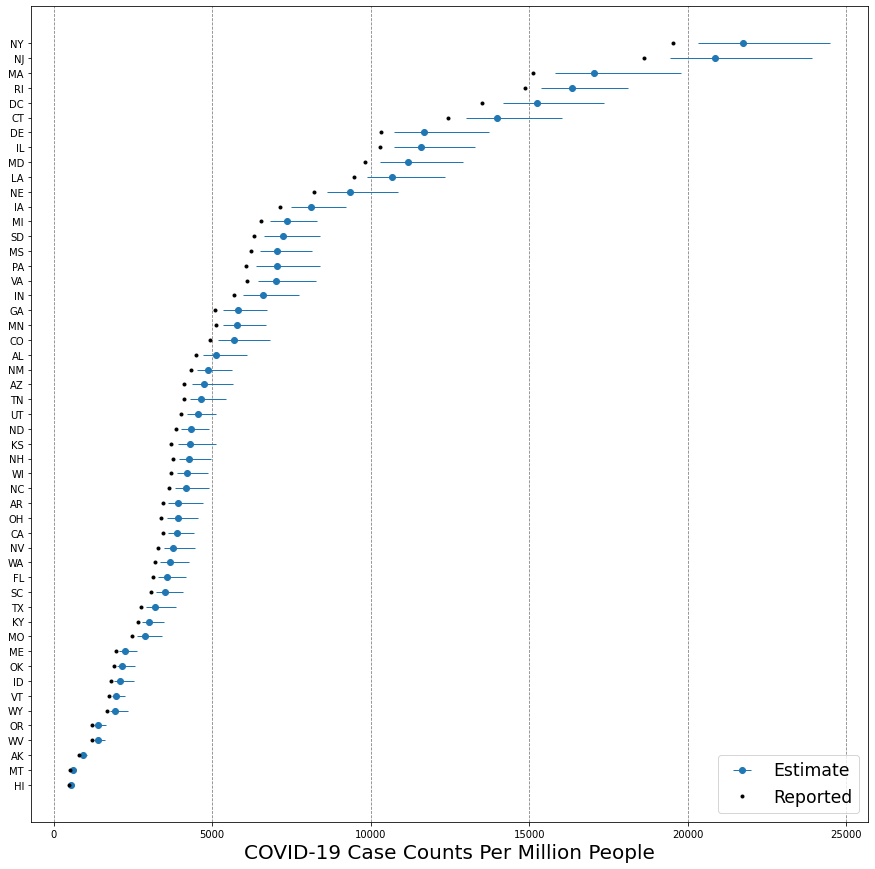

In [8]:
#hide_input

df_plot = df_summary.copy(deep=True)

# Compute predicted cases per million
df_plot['predicted_counts_now_pm'] =  1e6 * (
    df_pred['positive'] / prob_missing_now.mean(axis=0)) / df_pred['total_population']

df_plot['predicted_counts_now_lower_pm'] = 1e6 * (
    df_pred['positive'] / prob_missing_now.quantile(0.975, axis=0))/ df_pred['total_population']
df_plot['predicted_counts_now_upper_pm'] = 1e6 * (
    df_pred['positive'] / prob_missing_now.quantile(0.025, axis=0))/ df_pred['total_population']

df_plot.sort_values('predicted_counts_now_pm', ascending=False, inplace=True)

xerr = [
    df_plot['predicted_counts_now_pm'] - df_plot['predicted_counts_now_lower_pm'], 
    df_plot['predicted_counts_now_upper_pm'] - df_plot['predicted_counts_now_pm']]

fig, axs = plt.subplots(1, 1, figsize=(15, 15))
ax = plt.errorbar(df_plot['predicted_counts_now_pm'], range(len(df_plot)-1, -1, -1),
                  xerr=xerr, fmt='o', elinewidth=1, label='Estimate')
ax = plt.yticks(range(len(df_plot)), df_plot.index[::-1])
ax = plt.errorbar(df_plot['Cases per Million'], range(len(df_plot)-1, -1, -1),
                  xerr=None, fmt='.', color='k', label='Reported')
ax = plt.xlabel('COVID-19 Case Counts Per Million People', size=20)
ax = plt.legend(fontsize='xx-large', loc=4)
ax = plt.grid(linestyle='--', color='grey', axis='x')

## Appendix: Model Diagnostics 

### Derived relationship between Test Capacity and Case Under-reporting

Plotted is the estimated relationship between test capacity (in terms of people per test -- larger = less testing) and the likelihood a COVID-19 case is reported (lower = more under-reporting of cases).

The lines represent the posterior samples from our MCMC run (note the x-axis is plotted on a log scale).  The rug plot shows the current test capacity for each state (black '|') and the capacity one week ago (cyan '+').  For comparison, South Korea's testing capacity is currently at the very left of the graph (200 people per test).

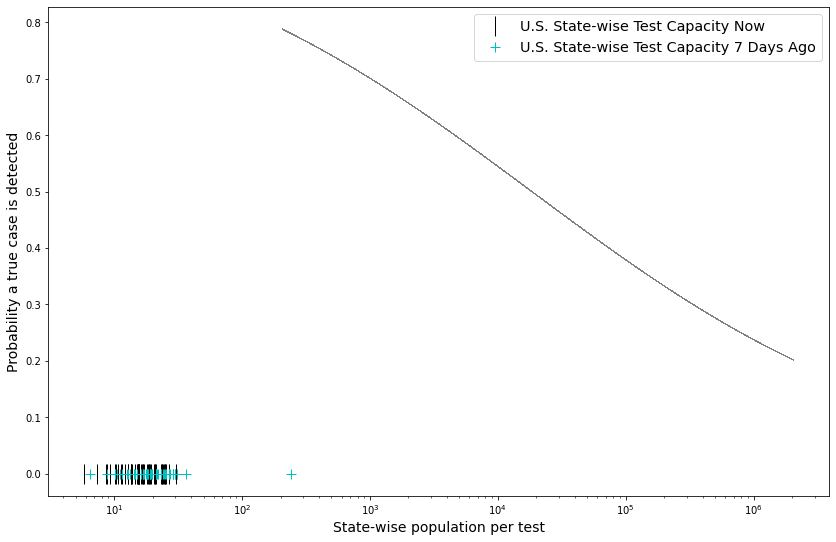

In [9]:
#hide_input

# Plot pop/test vs. Prob of case detection for all posterior samples:
x = np.linspace(0.0, 4.0, 101)
logit_pcase = pd.DataFrame([
    trace['alpha'][i] + trace['beta'][i] * x
    for i in range(n)])
pcase = np.exp(logit_pcase) / (np.exp(logit_pcase) + 1)

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
for i in range(n):
    ax = plt.plot(10**(ppt_sk + x), pcase.iloc[i], color='grey', lw=.1, alpha=.5)
    plt.xscale('log')
    plt.xlabel('State-wise population per test', size=14)
    plt.ylabel('Probability a true case is detected', size=14)

# rug plots:
ax=plt.plot(df_pred['people_per_test'], np.zeros(len(df_pred)),
            marker='|', color='k', ls='', ms=20,
           label='U.S. State-wise Test Capacity Now')
ax=plt.plot(df['people_per_test_7_days_ago'], np.zeros(len(df)),
            marker='+', color='c', ls='', ms=10,
           label='U.S. State-wise Test Capacity 7 Days Ago')
ax = plt.legend(fontsize='x-large')

## About this Analysis

This analysis was done by [Joseph Richards](https://twitter.com/joeyrichar).

This project[^1] uses the testing rates per state from [https://covidtracking.com/](https://covidtracking.com/), which reports case counts and mortality by state.  This is used to **estimate the number of unreported (untested) COVID-19 cases in each U.S. state.**

The analysis makes a few assumptions:

1. The probability that a case is reported by a state is a function of the number of tests run per person in that state.  Hence the degree of under-reported cases is a function of tests run per capita.
2. The underlying mortality rate is the same across every state.
3. Patients take time to succumb to COVID-19, so the mortality counts *today* reflect the case counts *7 days ago*.  E.g., mortality rate = (cumulative deaths today) / (cumulative cases 7 days ago).

The model attempts to find the most likely relationship between state-wise test volume (per capita) and under-reporting, such that the true underlying mortality rates between the individual states are as similar as possible.  The model simultaneously finds the most likely posterior distribution of mortality rates, the most likely *true* case count per state, and the test volume vs. case underreporting relationship.

[^1]: Full details about the model are available at:  https://github.com/jwrichar/COVID19-mortality